In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

words = open(r'data\names.txt','r').read().splitlines()

chars = sorted(list(set(''.join(words))))
chars = ['.'] + chars

char2idx = {c:i for i,c in enumerate(chars)}
idx2char = {i:c for c,i in char2idx.items()}

In [449]:
# Build dataset
import random

def build_data_set(words):
    xs , ys = [], []
    block_size = 3

    for word in words:
        # print(word)

        context = [0] * block_size
        for _chr in word+'.':
            ix = char2idx[_chr]
            xs.append(context)
            ys.append(ix)
        
            # print(''.join([idx2char[i] for i in context]),'->',_chr)
            context = context[1:] + [ix] # pop first, append ix

        # print()

    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys



random.seed(42)
random.shuffle(words)



n_train = int(len(words) * 0.8)
n_1 = int(len(words) * 0.9)

x_train , y_train = build_data_set(words[:n_train])
x_valid , y_valid = build_data_set(words[n_train:n_1])
x_test , y_test = build_data_set(words[n_1:])

total_train = len(x_train)
total_valid = len(x_valid)
total_test = len(x_test)

total_train, total_valid, total_test

(182424, 22836, 22886)

In [450]:
# What does "embedding in a n-dimensional space" mean?
i = F.one_hot(torch.tensor(2),num_classes=3).float()
matrix = torch.randn((3,4))

# These two are equivalent
print(i @ matrix)
print(matrix[2])

# matrix represents a 4 dimensional space, where we are embedding the integer 2. We can access the embedding by indexing into the matrix 
# or by doing dot product with its one-hot vector.

tensor([-1.1426, -1.9347,  0.2554, -2.3124])
tensor([-1.1426, -1.9347,  0.2554, -2.3124])


In [451]:
# Embed xs in an embedding space of dimension 2
embedding_space = torch.randn(total_train, 2)
embedding = embedding_space[x_train]

# This gives us embedding of the first charater in the dataset.
# Following 2 lines are equivalent
print(embedding_space[x_train[0]])
print(embedding[0])
print(embedding.shape)

tensor([[0.5500, 0.0427],
        [0.5500, 0.0427],
        [0.5500, 0.0427]])
tensor([[0.5500, 0.0427],
        [0.5500, 0.0427],
        [0.5500, 0.0427]])
torch.Size([182424, 3, 2])


In [305]:
# How tensors work
# - Tensors are stored as a linear array in memory
# - It's shape is interpreted by other attributes
# - `tensor.view` returns a new tensor with the same data, but different shape, as long as the params to view multiply 
# to the total number of elements in the tensor
a = torch.arange(18)
a.view(9,2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [452]:
# Intialize weights and biases
rand_gen = torch.Generator().manual_seed(2147483647)

# Embed xs in an embedding space of dimension 2
embedding_space = torch.randn((27,10), generator=rand_gen, requires_grad=True)

W1 = torch.randn((30,200), generator=rand_gen, requires_grad=True)
b1 = torch.randn(200, generator=rand_gen, requires_grad=True)
W2 = torch.randn((200,27), generator=rand_gen, requires_grad=True)
b2 = torch.randn(27, generator=rand_gen, requires_grad=True)

params = [W1,b1,W2,b2,embedding_space]


In [453]:
learning_rates_e = torch.linspace(-3,0, 1000)
learning_rates = 10**learning_rates_e

In [454]:
learning_rates_used = []
losses_for_each_lr = []
losses_per_step = []
step_i = []

Loss: 2.0939


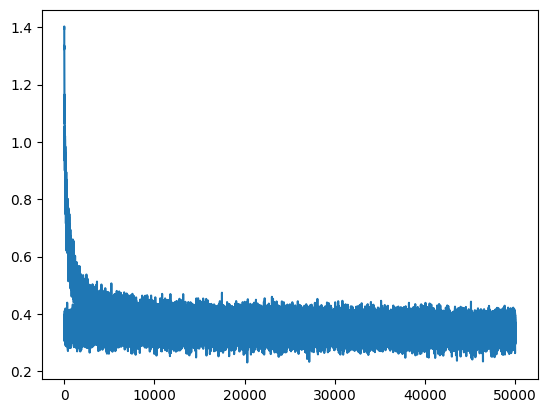

In [458]:

batch_size = 500

# forward pass
for i in range(50000):
    ix = torch.randint(0, x_train.shape[0], (batch_size,))

    embedding = embedding_space[x_train[ix]]
    activation_1 = torch.tanh(embedding.view(-1,30) @ W1 + b1) # -1 means "as many as needed", which is inferred from the dimensions of the other params
    logits = activation_1 @ W2 + b2


    # count = logits.exp()
    # probs = count / count.sum(dim=1, keepdim=True)
    # # index into probs with (batch_size, index) to get the probability of the correct character
    # i_batch = torch.arange(total_xs)
    # loss = -probs[i_batch,ys].log().mean()
    loss = F.cross_entropy(logits, y_train[ix])

    # backward pass
    for p in params:
        p.grad = None

    loss.backward(retain_graph=True)

    # update params
    for p in params:
        p.data -= 0.01 * p.grad # 0.1 is determined by plotting learning_rates_exponent vs loss and finding the point where loss is stable
        # p.data -= learning_rates[i] * p.grad


    # track learning rate vs loss
    # learning_rates_used.append(learning_rates_e[i])
    # losses_for_each_lr.append(loss.item())

    # track loss vs step
    losses_per_step.append(loss.log10().item())
    step_i.append(i)

print(f"Loss: {loss.item():.4f}")
plt.plot(step_i, losses_per_step)

In [459]:
# loss on the entire dataset
embedding = embedding_space[x_valid]
activation_1 = torch.tanh(embedding.view(-1,30) @ W1 + b1)
logits = activation_1 @ W2 + b2
loss = F.cross_entropy(logits, y_valid)
print(f"Loss: {loss.item():.4f}")

Loss: 2.1616


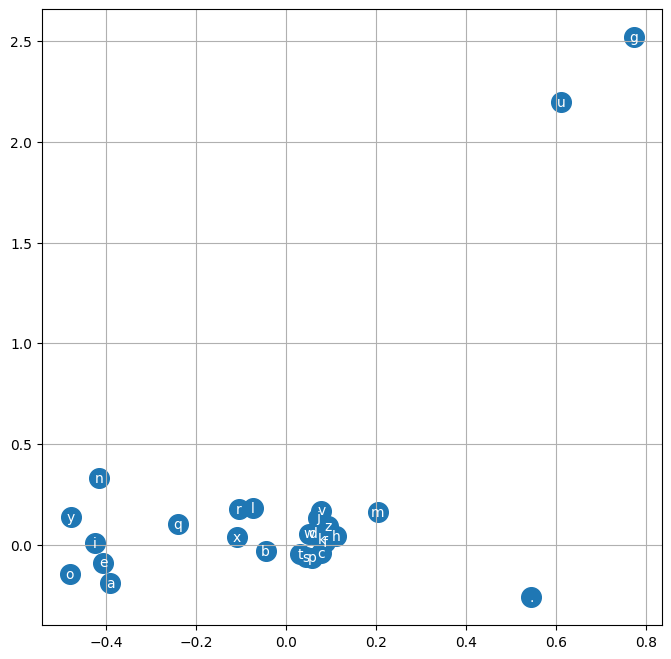

In [394]:
# Visualize the embedding space, only works for 2D embedding space

# emb_space = embedding_space[torch.arange(27)]
# plt.figure(figsize=(8,8))
# plt.scatter(emb_space[:,0].data, emb_space[:,1].data, s=200)
# for i in range(27):
#     plt.text(
#         emb_space[i,0].item(), 
#         emb_space[i,1].item(), 
#         idx2char[i], 
#         ha='center', 
#         va='center', 
#         color='white'
#     )

# plt.grid('minor')



In [461]:
# inference
rand_gen = torch.Generator().manual_seed(2147483647)
block_size = 3

for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        emb = embedding_space[
            torch.tensor([context])
        ]

        act_1 = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = act_1 @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1,generator=rand_gen).item()
        context = context[1:] + [ix]
        
        if ix == 0:
            break

        out.append(ix)

    print(''.join([idx2char[i] for i in out]))
    

cex
mariallura
carity
kell
immana
noluwan
katha
samiyah
javer
gotai
molise
kaugu
preda
kaley
maside
enka
graylynns
millie
bron
lus
